In [67]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, tzinfo
import pytz
from io import StringIO

In [77]:
class YoubikeSnapshot:
    def __init__(self, extraction_ts: datetime, body: str):
        self.extraction_ts = extraction_ts
        self.body = body

In [68]:
def get_youbike_data() -> YoubikeSnapshot:
    URL = 'https://gcs-youbike2-linebot.microprogram.tw/latest-data/youbike-station.csv'
    r = requests.request('GET', url)
    
    tz_tst = pytz.timezone('Asia/Taipei')
    time_now = datetime.today().now(tz=tz)
    data = YoubikeSnapshot(extraction_ts=time_now, body=r.text)
    return data

def basic_preprocessing(data: YoubikeSnapshot) -> YoubikeSnapshot:
    '''Attemps to apply simple preprocessing.
    Returns preprocessed data
    '''

    df = pd.read_csv(StringIO(data.body))
    df["last_update_ts"] = pd.to_datetime(df["updated_at"], unit="s")
    df.drop(labels=["updated_at"], axis=1, inplace=True)
    data.body = df.to_csv()
    return data

def download_basic_preprocessed_youbike_snapshot() -> str:
    data = get_youbike_data()
    file_stub = f'youbike_dock_info_{data.extraction_ts}_raw'
    try:
        preprocessed_data = basic_preprocessing(data)
    except:
        preprocessed_data = data
        file_stup += 'error'
        print("An error occured while preprocessing the data")
        
    file_path = file_stub + '.csv'
    with open(f'/raw_data/{file_path}', 'w') as f:
        f.write(preprocessed_data.body)
    return file_path

',test,string,last_update_ts\n0,a,b,1970-01-13 15:34:58\n'

In [75]:
download_basic_preprocessed_youbike_snapshot()

'youbike_dock_info_2024-02-15 19:08:46.307812+08:00_raw.csv'

In [76]:
#Pull data from API to memory
# Apply basic transformations, with try and error
# Save step 

In [50]:
last_data_path = get_youbike_data()
bikes_station_raw = pd.read_csv(last_data_path)

In [51]:
# Analyze Raw data
main_df = bikes_station_raw.copy()

# Double check with cleaned df 
# main_df = bikes_station_clean.copy()

# Validate & clean the dataset

In [53]:
main_df.shape

(7889, 17)

In [55]:
main_df.columns

Index(['id', 'name', 'type', 'space', 'full', 'empty', 'bike_yb1', 'bike_yb2',
       'bike_eyb', 'city', 'area', 'lat', 'lng', 'place_id', 'address',
       'is_open', 'updated_at'],
      dtype='object')

**Columns are understood as follows:**
- id: unique identifier per bike station
- type: ??
- space: total available bike slots per station (= full + empty)
- full: nbr of occupied slots 
- empty: nbr of available slots for parking
- bike_yb1: ??
- bike_yb2: ??
- bike_eyb: ??
- city: city where bike station is located
- area: city's district where bike station is located
- lat: latitude coordinate of bike station
- lng: longitude coordinate of bike station
- place_id: ??
- address: postal address of bike station
- is_open: ??
- updated_at: timestamp of data in unix epoch

### Check types & missing values

In [56]:
display(main_df.info())
display(main_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7889 entries, 0 to 7888
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          7889 non-null   int64  
 1   name        7889 non-null   object 
 2   type        7889 non-null   int64  
 3   space       7889 non-null   int64  
 4   full        7889 non-null   int64  
 5   empty       7889 non-null   int64  
 6   bike_yb1    7889 non-null   int64  
 7   bike_yb2    7889 non-null   int64  
 8   bike_eyb    7889 non-null   int64  
 9   city        7765 non-null   object 
 10  area        7889 non-null   object 
 11  lat         7889 non-null   float64
 12  lng         7889 non-null   float64
 13  place_id    0 non-null      float64
 14  address     7889 non-null   object 
 15  is_open     7889 non-null   int64  
 16  updated_at  7889 non-null   int64  
dtypes: float64(3), int64(10), object(4)
memory usage: 1.0+ MB


None

id               0
name             0
type             0
space            0
full             0
empty            0
bike_yb1         0
bike_yb2         0
bike_eyb         0
city           124
area             0
lat              0
lng              0
place_id      7889
address          0
is_open          0
updated_at       0
dtype: int64

**Observation**
- place_id contains no value
- city has empty values
- updated_at is an int64

In [57]:
main_df.drop(main_df[main_df["city"].isna()].index, inplace=True)
main_df["ts"] = pd.to_datetime(main_df["updated_at"], unit="s")
main_df.drop(labels=["place_id", "updated_at"], axis=1, inplace=True)

### Discard irrelevant features

In [10]:
main_df.drop(labels=["name", "area", "address"], axis=1, inplace=True)

### Check range and distribution of values

#### Categorical

In [11]:
main_df_cat = main_df.select_dtypes(include=["category", "object"])
#TODO: set "type" to a category var to include in categorical

In [12]:
for col in main_df_cat.columns:
    unique_values = main_df[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'city': ['台北市' '臺南市' '桃園市' '新北市' '苗栗縣' '高雄市' '嘉義市' '新竹縣' '屏東縣' '台中市' '新竹市'
 '新竹科學工業園區']


In [13]:
#Map city to ascii chars
city_name_glossary = {"新北市": "XinBeiShi",
                      "台北市": "TaiBeiShi",
                      "台中市":"TaiZhongShi",
                      "高雄市":"KaoXiongShi",
                      "桃園市":"TaoYuanShi",
                      "臺南市": "TaiNanShi",
                      "嘉義市": "JiaYiShi",
                      "屏東縣": "PingDongXian",
                      "新竹市": "XinZhuShi",
                      "新竹縣": "XinZhuXian",
                      "苗栗縣" : "MiaoLiXian",
                      "新竹科學工業園區": "XinZhuKeXueGong"}  

#TODO Need to catch KeyError and set default value. 
main_df["city"] = main_df.apply(lambda x: city_name_glossary[x["city"]], axis=1)


#### Numerical

In [14]:
main_df_num = main_df.drop(labels=main_df_cat.columns, axis=1)

In [15]:
main_df_num.describe()

,id,type,space,full,empty,bike_yb1,bike_yb2,bike_eyb,lat,lng,is_open,ts
count,7.730000e+03,7730.000000,7730.000000,7730.000000,7730.000000,7730.000000,7730.000000,7730.000000,7730.000000,7730.000000,7730.000000,7730
mean,4.324384e+08,1.863777,20.991850,6.090815,14.165071,0.756145,5.181242,0.153428,24.234585,120.693889,1.009832,2024-01-06 06:21:01.025485312
min,1.001000e+03,1.000000,0.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-06-21 04:43:40
25%,5.001090e+08,2.000000,14.000000,2.000000,8.000000,0.000000,0.000000,0.000000,23.478723,120.497398,1.000000,2024-01-06 09:38:17
50%,5.003041e+08,2.000000,18.000000,4.000000,12.000000,0.000000,3.000000,0.000000,24.939449,121.222856,1.000000,2024-01-06 09:38:17
75%,5.010011e+08,2.000000,25.000000,8.000000,18.000000,0.000000,7.000000,0.000000,25.032495,121.484830,1.000000,2024-01-06 09:38:17
max,5.082010e+08,2.000000,106.000000,88.000000,98.000000,79.000000,88.000000,14.000000,25.293010,122.000000,5.000000,2024-01-06 09:38:18
std,1.717423e+08,0.343047,11.580041,6.738314,10.196297,3.174189,6.498734,0.689649,1.525084,6.130140,0.389281,NaN


**Observations**
- Empty has negative values
- Some long/lat coordinates are outside of Taiwan
- Some ts shows stale data (many days older than latest ts)

In [16]:
discard_mask = (
    (main_df["empty"] < 0)
    | (main_df["space"] < 1) # Stations without space are irrelevant
    | (main_df["lat"] < 21.89) #southermost lat of Taiwan's main island
    | (main_df["lng"] < 120) #westernmost lng of Taiwan's main island
    | (main_df["ts"] < pd.to_datetime('now').normalize())
)
main_df.drop(main_df[discard_mask == True].index, inplace=True)
    

In [17]:
len(main_df_num.columns)

12

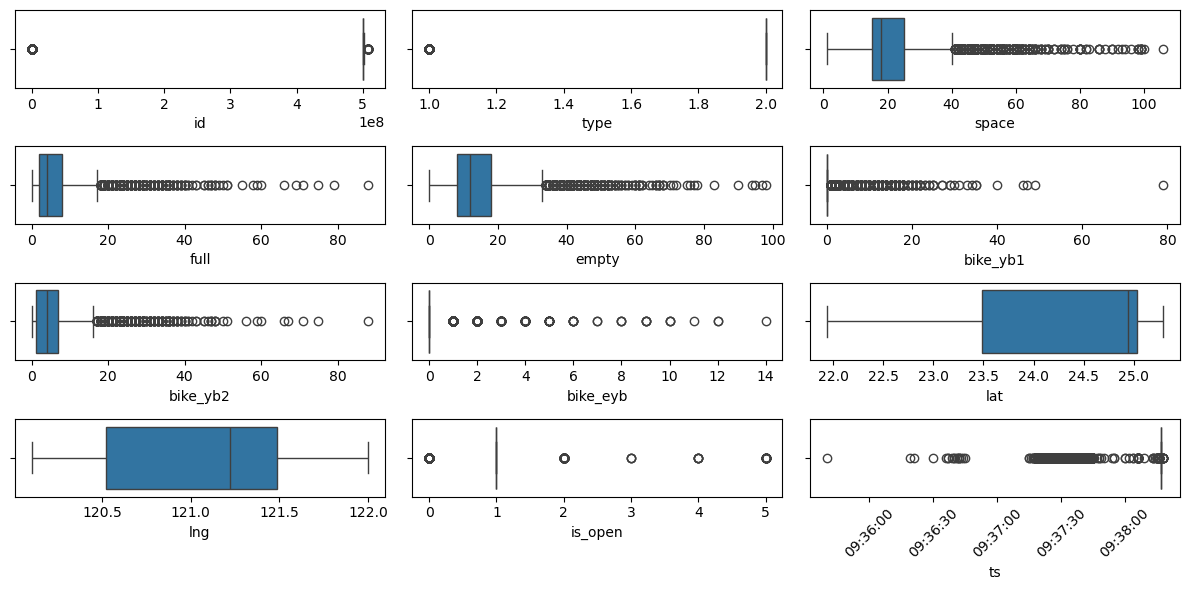

In [18]:
col_nb = 3
fig, ax = plt.subplots(4, col_nb, figsize=(12, 6))

main_df_num = main_df.drop(labels=main_df_cat.columns, axis=1)
for i, col_name in enumerate(main_df_num.columns):
    col = i % col_nb
    row = i // col_nb
    sns.boxplot(x=col_name, data=main_df_num, ax=ax[row, col], )
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust subplots to fit into the figure area.

plt.show()

**Observation:** Data is very heterogenous 

### Check uniqueness of data

#### id

In [19]:
id_counts = main_df["id"].value_counts()
id_counts[id_counts > 1]

Series([], Name: count, dtype: int64)

id is unique

#### lat/lng

In [20]:
lat_counts = main_df["lat"].value_counts()
lat_counts

lat
24.99039    4
24.98263    4
25.02332    4
25.07567    3
25.02565    3
           ..
22.74015    1
25.08471    1
25.07676    1
24.17893    1
25.00559    1
Name: count, Length: 6989, dtype: int64

In [22]:
main_df["gps"] = main_df.apply(lambda x: (x["lat"], x["lng"]), axis=1)

In [23]:
gps_counts = main_df["gps"].value_counts()
gps_counts[gps_counts > 1]

gps
(24.19870797, 120.660757)    3
(25.00653, 121.50014)        2
(25.000959, 121.317024)      2
(24.962275, 121.293209)      2
(24.986849, 121.294739)      2
                            ..
(25.19985, 121.42891)        2
(25.17476, 121.43155)        2
(24.90904, 121.28357)        2
(25.01086, 121.45598)        2
(24.93306, 121.22493)        2
Name: count, Length: 265, dtype: int64

In [24]:
main_df[main_df["lat"] == 24.977812]

,id,type,space,full,empty,bike_yb1,bike_yb2,bike_eyb,city,lat,lng,is_open,ts,gps
373,500306016,2,14,8,4,0,8,0,TaoYuanShi,24.977812,121.321076,1,2024-01-05 16:12:16,"(24.977812, 121.321076)"
7034,2041,1,36,25,6,25,0,0,TaoYuanShi,24.977812,121.321076,1,2024-01-05 16:11:28,"(24.977812, 121.321076)"


## TBD why the duplicates 

In [25]:
main_df["type"].isin([1])

6       False
8       False
9       False
11      False
12      False
        ...  
7847     True
7848     True
7849     True
7850     True
7851     True
Name: type, Length: 7634, dtype: bool

# Analyze Data


In [26]:
main_df_by_city = main_df.pivot_table(values="space", index="city", aggfunc=["sum"])

In [27]:
main_df_by_city.sort_values(by=("sum","space"))

,sum
,space
city,
XinZhuKeXueGong,740
XinZhuXian,1947
XinZhuShi,2468
JiaYiShi,2769
MiaoLiXian,2836
PingDongXian,2841
TaiNanShi,8140
TaoYuanShi,16390


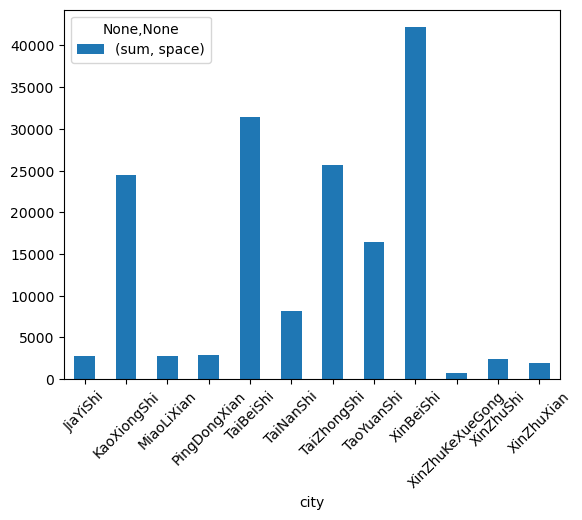

In [28]:
main_df_by_city.plot(kind="bar", rot=45)
plt.show()

In [29]:
print(main_df[["is_open"]].value_counts())

is_open
1          7335
0           175
2            86
5            30
4             5
3             3
Name: count, dtype: int64


In [30]:
main_df[(main_df["is_open"] == 0) & (main_df["empty"] >0)].loc[:,"type":"bike_eyb"].describe()

,type,space,full,empty,bike_yb1,bike_yb2,bike_eyb
count,40.0,40.000000,40.0,40.000000,40.0,40.0,40.0
mean,2.0,20.125000,0.0,20.075000,0.0,0.0,0.0
std,0.0,13.091762,0.0,13.160523,0.0,0.0,0.0
min,2.0,3.000000,0.0,2.000000,0.0,0.0,0.0
25%,2.0,10.000000,0.0,10.000000,0.0,0.0,0.0
50%,2.0,14.500000,0.0,14.500000,0.0,0.0,0.0
75%,2.0,32.250000,0.0,32.250000,0.0,0.0,0.0
max,2.0,50.000000,0.0,50.000000,0.0,0.0,0.0


In [31]:

main_df[(main_df["is_open"] > 1)]

,id,type,space,full,empty,bike_yb1,bike_yb2,bike_eyb,city,lat,lng,is_open,ts,gps
18,500799001,2,5,0,5,0,0,0,MiaoLiXian,24.612617,120.821200,5,2024-01-05 16:12:16,"(24.612617, 120.8212)"
464,500399001,2,26,0,26,0,0,0,TaoYuanShi,24.594650,121.151120,5,2024-01-05 16:12:16,"(24.59465, 121.15112)"
535,500211002,2,26,0,0,0,0,0,XinBeiShi,25.293010,121.536240,2,2024-01-05 16:12:16,"(25.29301, 121.53624)"
611,1702,1,16,0,16,0,0,0,XinBeiShi,25.108260,121.455960,2,2024-01-05 16:11:36,"(25.10826, 121.45596)"
903,500214063,2,16,0,0,0,0,0,XinBeiShi,25.097050,121.642410,2,2024-01-05 16:12:16,"(25.09705, 121.64241)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6921,501299003,2,25,0,25,0,0,0,KaoXiongShi,22.628844,120.293747,5,2024-01-05 16:12:16,"(22.628844, 120.293747)"
7080,2087,1,18,0,0,0,0,0,TaoYuanShi,24.973517,121.298761,2,2024-01-05 16:12:17,"(24.973517, 121.298761)"
7453,1129,1,64,0,0,0,0,0,XinBeiShi,25.045729,121.426269,2,2024-01-05 16:11:42,"(25.045729, 121.426269)"
7716,1437,1,12,0,12,0,0,0,XinBeiShi,25.099230,121.450630,2,2024-01-05 16:11:32,"(25.09923, 121.45063)"


In [31]:
from numpy.random import rand

In [48]:
main_df_dummy = main_df.copy(deep=True)
city_dummies = rand(main_df_dummy["city"].isna().sum())
main_df_dummy["city_na"] = main_df_dummy["city"].isna()

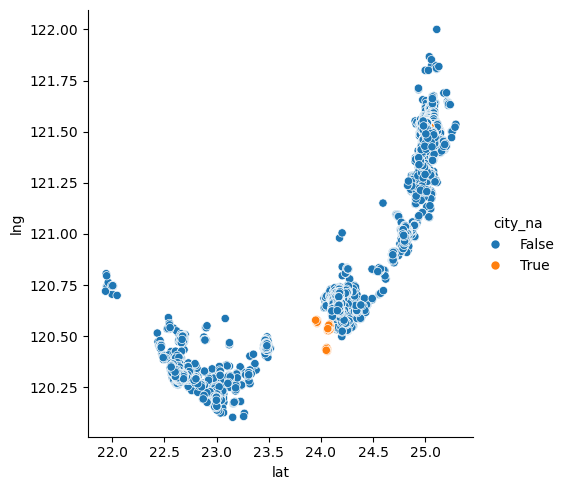

In [52]:
main_df[main_df_dummy["city"].isna()]
sns.relplot(kind="scatter", x="lat", y="lng", data=main_df_dummy[main_df_dummy["lat"] > 20], hue="city_na")

### Transfer to clean df

In [ ]:
bikes_station_clean = main_df.copy()

In [44]:
import numpy as np 
np.isnan(main_df_dummy["city"][0])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [47]:
main_df_dummy["city"].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
7849    False
7850    False
7851    False
7852    False
7853    False
Name: city, Length: 7854, dtype: bool